# Introduction to Convolutional Neural Networks ans Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as a camera of self-driving car recognizng the car in front.

In [1]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

## Get Data
The images we-re working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classes (pizza & steak) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

**Note:** We start with a smaller dataset so we can experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [3]:
import requests

import zipfile

import io



# Download the zip file using requests

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"

response = requests.get(url)



# Unzip the file in memory and extract it

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:

    zip_ref.extractall("pizza_steak")  # Extract to a folder called 'pizza_steak'

## Inspect the data (become one with it)

A very crucial step at beginning of any machine learning project is becoming one with the data.

And for a computer vision project... this usually means visualizing many samples of your data.

In [60]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk('../data/pizza_steak'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 3 directories and 0 images in ../data/pizza_steak
There are 0 directories and 3 images in ../data/pizza_steak\custom_data
There are 2 directories and 0 images in ../data/pizza_steak\test
There are 0 directories and 250 images in ../data/pizza_steak\test\pizza
There are 0 directories and 250 images in ../data/pizza_steak\test\steak
There are 2 directories and 0 images in ../data/pizza_steak\train
There are 0 directories and 750 images in ../data/pizza_steak\train\pizza
There are 0 directories and 750 images in ../data/pizza_steak\train\steak


In [61]:
# Anather way to find out how many images are in a file
num_steak_images_train = len(os.listdir("../data/pizza_steak/train/steak"))

num_steak_images_train

750

To visualize our images, first let's get the class names programmatically

In [62]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("../data/pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [63]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup the targeet dirctory (we'll view images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (512, 512, 3)


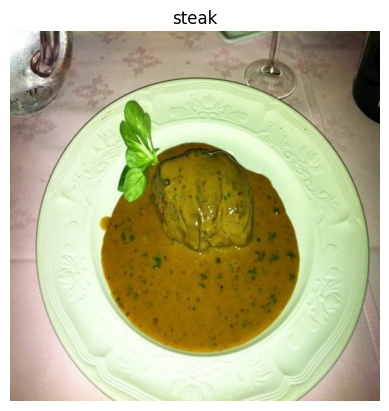

In [64]:
# View the training image from the training dataset
img = view_random_image(target_dir="../data/pizza_steak/train/",
                        target_class="steak")

In [7]:
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 52,  42,  30],
        [ 50,  40,  28],
        [ 51,  39,  27],
        ...,
        [  0,   2,   0],
        [  0,   2,   0],
        [  0,   2,   0]],

       [[ 48,  38,  26],
        [ 47,  37,  25],
        [ 49,  37,  25],
        ...,
        [  1,   3,   0],
        [  0,   2,   0],
        [  0,   2,   0]],

       [[ 45,  33,  19],
        [ 46,  34,  20],
        [ 47,  35,  21],
        ...,
        [  1,   3,   0],
        [  1,   3,   0],
        [  1,   3,   0]],

       ...,

       [[130,  82,  16],
        [131,  83,  17],
        [130,  82,  16],
        ...,
        [ 79,  50,   8],
        [ 80,  51,  11],
        [ 78,  49,   9]],

       [[136,  88,  22],
        [135,  87,  21],
        [133,  85,  19],
        ...,
        [ 88,  56,  15],
        [ 89,  57,  18],
        [ 87,  55,  16]],

       [[135,  87,  21],
        [138,  90,  24],
        [138,  90,  24],
        ...,
        [ 84,  53,   

In [53]:
# View the image shape
img.shape # returns width, height, colour channels

(512, 512, 3)

> **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also reffered to as **normilize**) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value). 

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we are need way to:
* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

> Outdated version

In [65]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup path to our directory
train_dir = '../data/pizza_steak/train'
test_dir = '../data/pizza_steak/test'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

print(valid_data.samples)

# Build a CNN model (same as the Tiny VGG on the CNN explainer webside)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),  # Явное указание входной формы
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                       epochs=5,
                       validation_data=valid_data,
                       validation_steps=None
                       )

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
500
Epoch 1/5


C:\Users\79279\Documents\IT\data_sciense\daniel_bourke_course\datascience\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - accuracy: 0.5464 - loss: 0.6736 - val_accuracy: 0.8240 - val_loss: 0.4230
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.8071 - loss: 0.4332 - val_accuracy: 0.8200 - val_loss: 0.3658
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.8206 - loss: 0.3885 - val_accuracy: 0.8540 - val_loss: 0.3380
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.8254 - loss: 0.4049 - val_accuracy: 0.8360 - val_loss: 0.3849
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.8602 - loss: 0.3395 - val_accuracy: 0.8640 - val_loss: 0.3260


> Updated version

In [7]:
# Import tools
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory as Images

# Set seed
tf.random.set_seed(1)

# Set directory
images_dir_train = "../data/pizza_steak/train"
images_dir_test = "../data/pizza_steak/test"

# Load images and split them into batches (NO NEED TO DEFINE HOW MANY CLASSES HERE, SINCE IT WILL BE INFERRED FROM DIRECTORY STRUCTURE AUTOMATICALLY)
# Load images and split them into batches
train_data = Images(
    images_dir_train,
    image_size = (224, 224),
    batch_size = 32
)

test_data = Images(
    images_dir_test,
    image_size = (224, 224),
    batch_size = 32
)

# Set number of classes
num_classes = len(train_data.class_names)

# Build model, indicating Rescaling layer as a first layer
model_1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Compile model
model_1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Train model
history_1 = model_1.fit(
  train_data,
  validation_data=test_data,
  epochs=5
)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.5939 - loss: 0.9061 - val_accuracy: 0.7560 - val_loss: 0.4995
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 276ms/step - accuracy: 0.7895 - loss: 0.4653 - val_accuracy: 0.8420 - val_loss: 0.3882
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - accuracy: 0.8349 - loss: 0.3967 - val_accuracy: 0.8500 - val_loss: 0.3161
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.8614 - loss: 0.3363 - val_accuracy: 0.8700 - val_loss: 0.2877
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.9040 - loss: 0.2494 - val_accuracy: 0.8780 - val_loss: 0.2969


In [8]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,366,024 (31.91 MB)

 Trainable params: 2,788,674 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,577,350 (21.28 MB)

## Using the same model as before

Let's replicate the model we've build in a previous section to see if it works with our image data.

The model we're building is from Tensorflow playground

In [9]:
# Set random 
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                       )

Epoch 1/5


C:\Users\79279\Documents\IT\data_sciense\daniel_bourke_course\datascience\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4802 - loss: 25.9955 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5167 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4903 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5085 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5090 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931


In [10]:
# Get a summary of model_2
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │         602,116 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,806,425 (6.89 MB)

 Trainable params: 602,141 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204,284 (4.59 MB)

> Despite having 20x more parameters than our CNN (model_1), model_2 performs terrible. Let's try to improve it.

In [11]:
# Set the random seed
tf.random.set_seed(42)

# Create the model (same as model_2)
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5670 - loss: 2853.1746 - val_accuracy: 0.6000 - val_loss: 413.6845
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6882 - loss: 345.0073 - val_accuracy: 0.7960 - val_loss: 124.3890
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7532 - loss: 138.8020 - val_accuracy: 0.7600 - val_loss: 75.1810
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7059 - loss: 222.6112 - val_accuracy: 0.7480 - val_loss: 190.2239
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7478 - loss: 141.1747 - val_accuracy: 0.7620 - val_loss: 46.6295


In [12]:
# Get the model_3 summary
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │      15,052,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,189,305 (172.38 MB)

 Trainable params: 15,063,101 (57.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,126,204 (114.92 MB)

> **Note:** You can think of trainable parameters as **patterns a model can learn from data**, Intuitively, you might think more is better. And in lots of cases, it is. But in this case, the difference here is two different styles of model we're using. Where a series of dense layers has a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a CNN seeks to sort out and learn the most important patterns in an image**. So even though these are less learnable parameters in our CNN, these are often more helphul in dechiphering between different **features** in an image.

## Binary Classification: Let's break it down

1. Become one with data (visualize, visualize, visualize)
2. Preprocess the data (prepared it for our model, the main step here was scalling/normalizing)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment)

### 1. Become one with the data

Image shape: (384, 512, 3)
Image shape: (512, 512, 3)


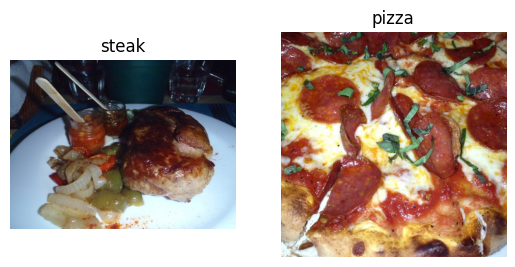

In [10]:
import os

# Visualize data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("../data/pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("../data/pizza_steak/test/", "pizza")
plt.show();

### 2. Preprocess the data (prepare it for a model)

In [11]:
# Define directory dataset paths
train_dir = "../data/pizza_steak/train/"
test_dir = "../data/pizza_steak/test/"

> Our next step is turn our data into **batches**
> 
> A batch is a small subset of data. Rather than look at all over 10 000 images at one time, a model might only look at 32 at time.
>
> It does this for a couple of reasons:
> 1. 10 000 images (or more) might not fit into the memory of your processor (GPU)
> 2. Trying to learn the patterns in 10 000 images in one hit could result in the model not being able to learn very well.
>
> Why 32?
>
> Becouse 32 is good for your helth.


In [12]:
# Create train and test data generators and rescale the data
 
# Create our train and test dataset:
from tensorflow.keras.preprocessing import image_dataset_from_directory
 
train_data = image_dataset_from_directory(directory=train_dir,
                                          label_mode="binary",
                                          batch_size=32,
                                          image_size=(224, 224),
                                          seed=42)
 
test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="binary",
                                         batch_size=32,
                                         image_size=(224, 224),
                                         seed=42)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [13]:
# How many batches are there
len(train_data)

47

In [14]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [15]:
# Images and labels in train_data
for image, label in train_data.take(1):
    print('Image: ', image)
    print(' ')
    print('Label: ', label)

Image:  tf.Tensor(
[[[[1.07108734e+02 5.56578445e+01 1.64748096e+01]
   [1.08562500e+02 5.71116104e+01 1.79285717e+01]
   [1.03031250e+02 5.33973236e+01 1.66428566e+01]
   ...
   [5.55169392e+00 5.11604977e+00 2.37333035e+00]
   [1.86926973e+00 1.71238685e+00 0.00000000e+00]
   [1.16994262e+00 3.28760195e+00 0.00000000e+00]]

  [[1.05647003e+02 5.71961098e+01 1.71961098e+01]
   [1.06379463e+02 5.79285736e+01 1.79285717e+01]
   [1.01547516e+02 5.51948357e+01 1.68389664e+01]
   ...
   [3.19642830e+00 2.29303837e+00 1.19482422e+00]
   [5.79743087e-01 2.32504323e-01 0.00000000e+00]
   [8.69531989e-01 3.90461206e+00 1.09821415e+00]]

  [[1.02938454e+02 5.88606491e+01 1.73571434e+01]
   [1.04098213e+02 6.05433655e+01 1.87783813e+01]
   [1.02111290e+02 5.80264664e+01 1.90264683e+01]
   ...
   [4.08482122e+00 3.39284897e-01 1.69642448e-01]
   [3.39918756e+00 3.40524745e+00 3.52995133e+00]
   [0.00000000e+00 2.83434606e+00 6.05306244e+00]]

  ...

  [[6.00000000e+00 1.83032227e+00 9.15161133e-0

### 3. Create a CNN model (start with baseline)

A baseline is a relatively simple model or existing result that you setup when begining a machine learning experiment and then as you keep experimenting, you try to beat the baseline.

> **Note:** In deep learning, there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (e.g. look at which current model is performing best in the field for your problem)

In [10]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input, Rescaling, Activation, GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [17]:
# Create the model (this will be our baseline, a layer convolutional neural network)
model_4 = Sequential([
    Input(shape=(224, 224, 3)),
    Rescaling(scale=1/255.),
    Conv2D(filters=10, # filters is the number of sliding windows going across an input (higher = more complex model)
           kernel_size=3, # the size of the sliding window going across an input 
           strides=1, # the size of the step the sliding window takes across an input
           padding="valid", # if 'same' output shape is same as input shape, if 'valid' output shape gets compressed
           activation="relu"),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid') # Output layer
])

In [18]:
# Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [19]:
#  Get a summary of our model
model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 218, 218, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 475240)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         475,241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 477,341 (1.82 MB)

 Trainable params: 477,341 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

### 4. Fit the model

In [20]:
# Check the length of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [21]:
# Fit the model
history_4 = model_4.fit(train_data, # this is a combination of labels and sample data
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.6293 - loss: 2.4999 - val_accuracy: 0.7680 - val_loss: 0.4691
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.7990 - loss: 0.4444 - val_accuracy: 0.7900 - val_loss: 0.4437
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.8377 - loss: 0.3878 - val_accuracy: 0.8100 - val_loss: 0.3904
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.8847 - loss: 0.3177 - val_accuracy: 0.7960 - val_loss: 0.4255
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.8992 - loss: 0.2540 - val_accuracy: 0.8200 - val_loss: 0.3960


In [22]:
model_1.evaluate(test_data)

ValueError: Cannot take the length of shape with unknown rank.

In [39]:
model_4.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8284 - loss: 0.3833 


[0.3959837555885315, 0.8199999928474426]

### 5. Evaluate the model

It looks like our model is learning something, let's evaluate it.

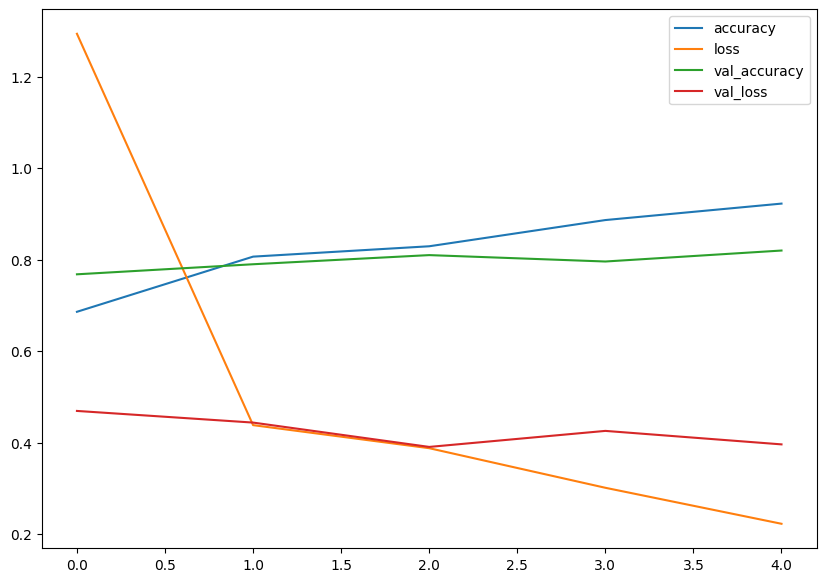

In [40]:
# Let's plot a training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

In [24]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training ans validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history["loss"])) # how many epochs did we run for?

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend();

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend();

> **Note:** When a model's **validation loss starts to increase**, it's a likely that the model is **overfitting** the training dataset. This means, it's learning the patterns in the training dataset too *well* and thus the model's ability to generalize to unseen data will be deminished.

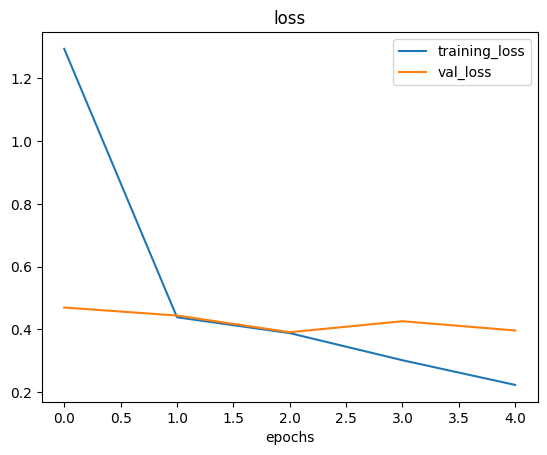

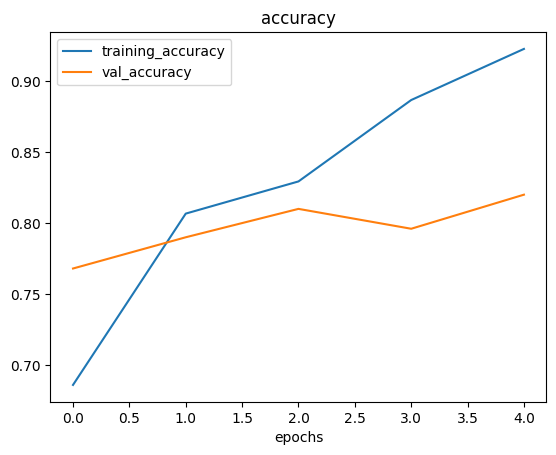

In [42]:
# Check out the loss and accuracy of model_4
plot_loss_curves(history_4)

> **Note:** Ideally the two loss curves (training and validation) will be very similar to each other (training loss and validation loss decreasing at similar rates), when there are large differences your model may be **overfitting**.

### 6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:

0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce overfitting

Ways to induce overfitting:
* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattened layer

Reduce overfitting:
* Add data augmentation
* Add regularization layers (such as MaxPool2D)
* Add more data...

> **Note:** Reducing overfitting is also known as **regularization**

In [43]:
# Create the model (this is going to be our new baseline)
model_5 = Sequential([
    Input(shape=(224, 224, 3)),
    Rescaling(scale=1/255.),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [44]:
# Compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

In [45]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5697 - loss: 0.6868 - val_accuracy: 0.7540 - val_loss: 0.5086
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.7572 - loss: 0.5106 - val_accuracy: 0.8540 - val_loss: 0.3911
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8212 - loss: 0.4122 - val_accuracy: 0.8860 - val_loss: 0.3358
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.8532 - loss: 0.3706 - val_accuracy: 0.8740 - val_loss: 0.3213
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8702 - loss: 0.3370 - val_accuracy: 0.8960 - val_loss: 0.2845


In [46]:
# Get a summary of our model with max pooling
model_5.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 111, 111, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 54, 54, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 52, 52, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 26, 26, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           6,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

In [47]:
model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 218, 218, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 475240)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         475,241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,432,025 (5.46 MB)

 Trainable params: 477,341 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 954,684 (3.64 MB)

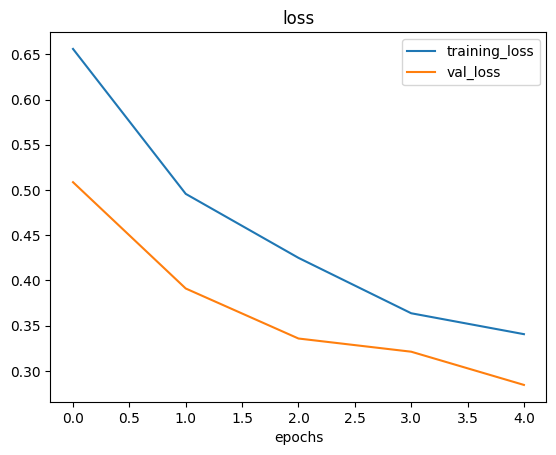

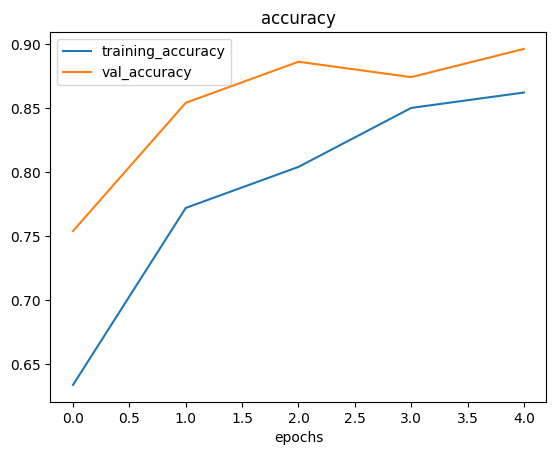

In [48]:
# Plot loss curves
plot_loss_curves(history_5)

### Opening our bag of tricks and finding data augmentation

> **Question:** What is data augmentation?

Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learns more generalizable (hopefully) patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar

In [49]:
# Создаем слой аугментации
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),  # Случайное отражение по горизонтали
    layers.RandomRotation(0.2),       # Поворот на ±20%
    layers.RandomZoom(0.2),           # Случайное увеличение/уменьшение
    layers.RandomContrast(0.1),       # Изменение контраста
    layers.RandomWidth(0.2),          # Случайное изменение ширины
    layers.RandomHeight(0.3),         # Случайное изменение высоты
], name="data_augmentation")

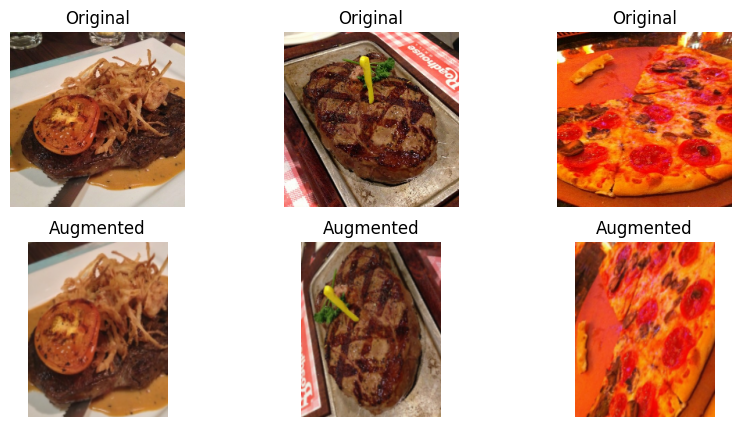

In [50]:
for images, _ in train_data.take(1):
    # Применить аугментацию
    augmented_images = data_augmentation(images)
    
    # Отобразить исходные и аугментированные изображения
    plt.figure(figsize=(10, 5))
    for i in range(3):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, 3, i + 4)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")
    plt.show()

In [51]:
# Модель с аугментацией
model_6 = Sequential([
    Input(shape=(224, 224, 3)),
    data_augmentation,                # Аугментация
    Rescaling(scale=1/255.),           # Нормализация [0, 255] → [0, 1]
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    GlobalAveragePooling2D(),         # Используем GlobalAveragePooling2D вместо Flatten
    Dense(1, activation='sigmoid')
])

In [52]:
# Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=Adam(),
               metrics=["accuracy"])

In [53]:
# Fit the model
history_6 = model_6.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.5110 - loss: 0.6933 - val_accuracy: 0.6160 - val_loss: 0.6843
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.6017 - loss: 0.6797 - val_accuracy: 0.5320 - val_loss: 0.6981
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.6228 - loss: 0.6616 - val_accuracy: 0.7020 - val_loss: 0.6283
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.6497 - loss: 0.6236 - val_accuracy: 0.7220 - val_loss: 0.5799
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.6876 - loss: 0.5889 - val_accuracy: 0.7460 - val_loss: 0.5439


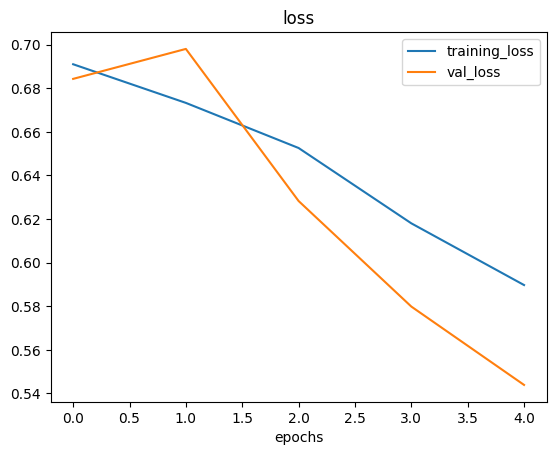

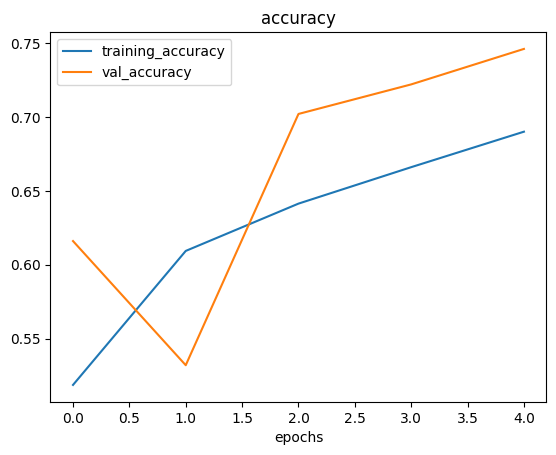

In [54]:
# Let's plot training curves
plot_loss_curves(history_6)

 >Let's shuffle our augmented training data ant train another model (the same as before) on it and see what happens

In [66]:
# Create our shuffled train and test dataset:
from tensorflow.keras.preprocessing import image_dataset_from_directory
 
train_data_shuffled = image_dataset_from_directory(directory=train_dir,
                                          label_mode="binary",
                                          batch_size=32,
                                          image_size=(224, 224),
                                          seed=42, 
                                          shuffle=True)
 
test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="binary",
                                         batch_size=32,
                                         image_size=(224, 224),
                                         seed=42)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [67]:
# Create the model (same as model_5 and model_6)
# Создаем слой аугментации
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),  # Случайное отражение по горизонтали
    layers.RandomRotation(0.2),       # Поворот на ±20%
    layers.RandomZoom(0.2),           # Случайное увеличение/уменьшение
    layers.RandomContrast(0.1),       # Изменение контраста
    layers.RandomWidth(0.2),          # Случайное изменение ширины
    layers.RandomHeight(0.3),         # Случайное изменение высоты
], name="data_augmentation")

# Модель с аугментацией
model_7 = Sequential([
    Input(shape=(224, 224, 3)),
    data_augmentation,                # Аугментация
    Rescaling(scale=1/255.),           # Нормализация [0, 255] → [0, 1]
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    GlobalAveragePooling2D(),         # Используем GlobalAveragePooling2D вместо Flatten
    Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_shuffled,
                        epochs=10,
                        validation_data=test_data)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.5166 - loss: 0.6908 - val_accuracy: 0.6300 - val_loss: 0.6776
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.5805 - loss: 0.6778 - val_accuracy: 0.5460 - val_loss: 0.6842
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.6021 - loss: 0.6611 - val_accuracy: 0.6320 - val_loss: 0.6346
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.6563 - loss: 0.6226 - val_accuracy: 0.6760 - val_loss: 0.6009
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.6635 - loss: 0.6013 - val_accuracy: 0.6840 - val_loss: 0.5888
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.6699 - loss: 0.5924 - val_accuracy: 0.7200 - val_loss: 0.5547
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.7195 - loss: 0.5616 - val_accuracy: 0.7260 - val_loss: 0.5437
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.7052 - loss: 0.5602 - val_accur

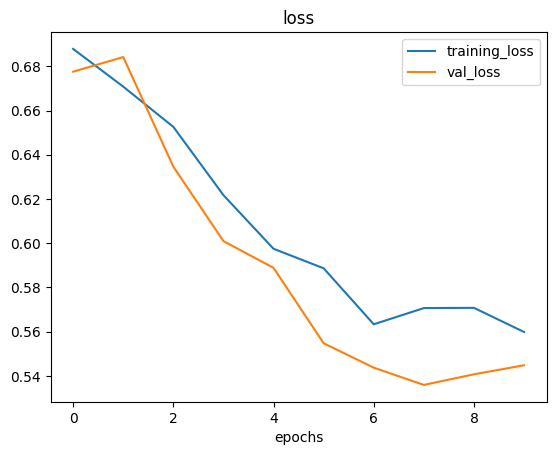

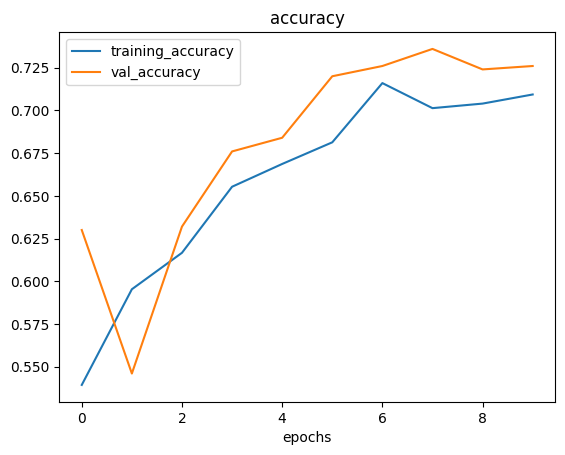

In [68]:
# Plot loss curves
plot_loss_curves(history_7)

In [87]:
model_6.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7503 - loss: 0.5363


[0.5439121127128601, 0.7459999918937683]

In [88]:
model_7.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7881 - loss: 0.4834


[0.4806583523750305, 0.7940000295639038]

> **Note:** When shuffling training data, the model gets exposed to all different kinds of data during training, thus enabling it to learn features across a wide array of images (in our case, pizza & steak at the same time instead of just pizza then steak).

### 7. Repeat until sutisfied

Since we've already beaten our baseline, there are a few things we could try to continue to imrove our model:

* Increase the number of model layers (e.g. add more `Conv2D` / `MaxPool2D` layers)
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32 or even 64)
* Train for longer (more epochs)
* Find an ideal learning rate
* Get more data (give the model more oportunities to learn)
* Use **transfer learning** to leverage what another image model has learn and adjust it for our own use case.

### Making prediction with our trained model on our own custom **data**

In [69]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


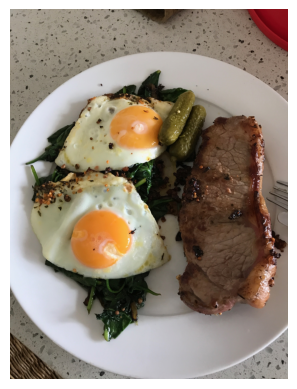

In [70]:
# View our example image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

steak = mpimg.imread("../data/pizza_steak/custom_data/03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [71]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

> **Note:** When you train a neural network and you want to make a prediction with it own custom data, it's important than your custom data(or new data) is processed into the same format as the data your model was trained on.

In [85]:
# Create a function to import an image and resize it to be able to use it in our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, colour_chanels).
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode the read file into a tensor
    img = tf.image.decode_image(img)
    # Resize the image
    img_resized = tf.image.resize(img, size=[img_shape, img_shape])
    # Rescale the image (get all values between 0 and 1)
    img_rescaling = img_resized/255.
    return [img_resized, img_rescaling]

In [94]:
# Load in and preprocess our custom image
filename = "../data/pizza_steak/custom_data/03-steak.jpeg"
steak_res, steak_resc = load_and_prep_image(filename, img_shape=224)
steak_res

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[162.625, 158.625, 147.625],
        [165.875, 161.125, 150.375],
        [161.125, 155.125, 143.125],
        ...,
        [133.   ,  13.   ,  23.   ],
        [126.25 ,  10.75 ,  18.   ],
        [134.75 ,  19.75 ,  26.75 ]],

       [[168.75 , 164.75 , 155.75 ],
        [162.875, 158.875, 146.875],
        [167.25 , 161.25 , 149.25 ],
        ...,
        [136.5  ,  17.5  ,  23.5  ],
        [135.125,  15.125,  24.125],
        [131.125,  14.125,  22.125]],

       [[166.25 , 162.25 , 150.25 ],
        [163.   , 156.5  , 144.75 ],
        [167.375, 159.875, 148.625],
        ...,
        [135.5  ,  16.5  ,  20.5  ],
        [134.5  ,  17.5  ,  25.5  ],
        [133.25 ,  13.25 ,  22.25 ]],

       ...,

       [[125.75 , 109.   ,  79.125],
        [ 13.875,   4.875,   0.   ],
        [ 54.25 ,  41.25 ,  24.25 ],
        ...,
        [156.375, 151.375, 145.375],
        [166.5  , 161.5  , 155.5  ],
        [163.625, 160.6

In [95]:
pred = model_7.predict(tf.expand_dims(steak_resc, axis=0))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[0.9709309]], dtype=float32)

> Looks like our custom image is being put through our model, however, it surrently outputs a prediction probability, wouldn't it be nice if we could visualize the image as well as the model's prediction

In [96]:
# Remind ourselves of our class names
class_names

array(['pizza', 'steak'], dtype='<U5')

In [97]:
# We can index the predicted class by rounding the prediction probability and indexing it on the class names
pred_class = class_names[int(tf.round(pred))]
pred_class

'steak'

In [98]:
def pred_and_plot(model, filename, class_names=class_names):
    """
    Imports an image located at filename, makes a prediction with model 
    and plots the image with the predicted class as the title
    """
    # Import the target image and preprocess it
    img_res, img_resc = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img_res, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred))]
    
    # Plot the image and predicted class
    plt.imshow(img_resc)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


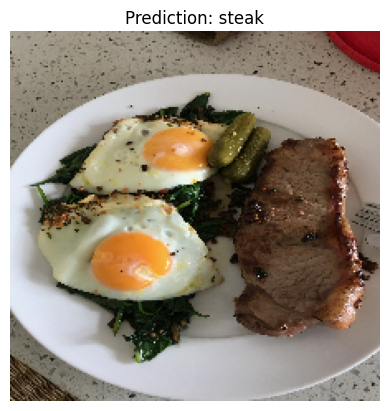

In [99]:
# Test our model on a custom image
pred_and_plot(model_7, filename)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


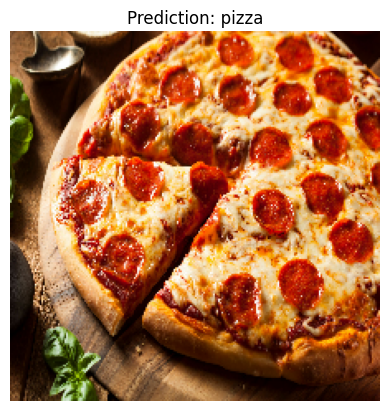

In [116]:
# Download another test custom image and make a prediction on it
filename = '../data/pizza_steak/custom_data/950395.jpg'
pred_and_plot(model_7, filename)

# Multi-class Image Classification

We've just been through a bunch of the following steps with a binary classification problem (pizza vs steak), now we're going to step things up a notch with 10 classes of food (multi-class classification)

1. Become one with data
2. Preprocess the data (get it ready for a model)
3. Create a model (start with baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust different hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat until satisfied

## 1. Import and become one with data

In [11]:
import requests
import zipfile
import io

# Download the zip file using requests
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"
response = requests.get(url)

# Unzip the file in memory and extract it
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall("pizza_steak")

KeyboardInterrupt: 

In [12]:
import os

# Walk through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("../data/10_food_classes_all_data/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '../data/10_food_classes_all_data/'
There are 10 directories and 0 images in '../data/10_food_classes_all_data/test'
There are 0 directories and 250 images in '../data/10_food_classes_all_data/test\chicken_curry'
There are 0 directories and 250 images in '../data/10_food_classes_all_data/test\chicken_wings'
There are 0 directories and 250 images in '../data/10_food_classes_all_data/test\fried_rice'
There are 0 directories and 250 images in '../data/10_food_classes_all_data/test\grilled_salmon'
There are 0 directories and 250 images in '../data/10_food_classes_all_data/test\hamburger'
There are 0 directories and 250 images in '../data/10_food_classes_all_data/test\ice_cream'
There are 0 directories and 250 images in '../data/10_food_classes_all_data/test\pizza'
There are 0 directories and 250 images in '../data/10_food_classes_all_data/test\ramen'
There are 0 directories and 250 images in '../data/10_food_classes_all_data/test\steak'
There are 0 d

In [13]:
# Setup the train and test directories
train_dir = "../data/10_food_classes_all_data/train/"
test_dir = "../data/10_food_classes_all_data/test/"

In [14]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 512, 3)


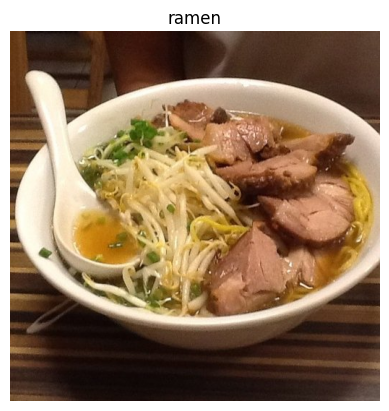

In [15]:
# Visualize, visialize, visualize
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(list(class_names)))                       

## 2. Preprocess the data (prepare it for a model)

In [17]:
# Create our train and test dataset:
from tensorflow.keras.preprocessing import image_dataset_from_directory
 
train_data = image_dataset_from_directory(directory=train_dir,
                                          label_mode="categorical",
                                          batch_size=32,
                                          image_size=(224, 224),
                                          seed=42)
 
test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="categorical",
                                         batch_size=32,
                                         image_size=(224, 224),
                                         seed=42)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## 3. Create and fit a model (start with a baseline)

We've been talking a lot about the CNN explainer website...
how abaout we just take their model (also on 10 classes) and use it for our problem?

In [34]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Rescaling, Input, Flatten, Rescaling, Activation

# Create a model (very similar to previous models but actually the same as CNN explainer website)
model_8 = Sequential([
    Input(shape=(224, 224, 3)),
    Rescaling(scale=1/255.),
    Conv2D(10, 3),
    Activation(activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax')
])

# Compile the model
model_8.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Fit the model
history_8 = model_8.fit(train_data,
           epochs=5,
           validation_data=test_data)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 173ms/step - accuracy: 0.1405 - loss: 2.2731 - val_accuracy: 0.2636 - val_loss: 2.0706
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.2867 - loss: 2.0012 - val_accuracy: 0.2996 - val_loss: 1.9461
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 49s 208ms/step - accuracy: 0.3864 - loss: 1.7711 - val_accuracy: 0.2992 - val_loss: 1.9898
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 52s 223ms/step - accuracy: 0.5157 - loss: 1.4630 - val_accuracy: 0.2908 - val_loss: 2.1684
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 46s 195ms/step - accuracy: 0.6961 - loss: 0.9389 - val_accuracy: 0.2736 - val_loss: 2.9655


## 4. Evaluate the model

In [23]:
# Evaluate on the test data
model_8.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2804 - loss: 2.9376


[2.965496778488159, 0.2736000120639801]

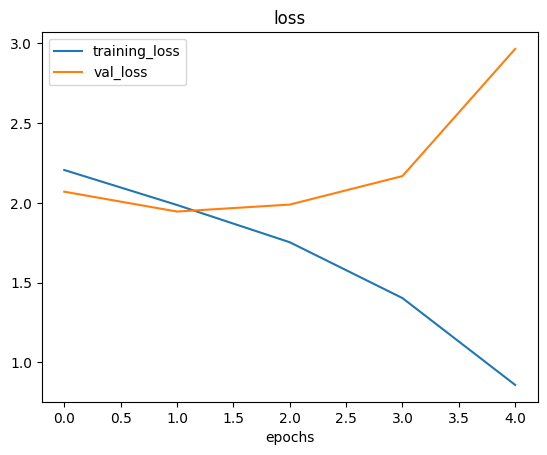

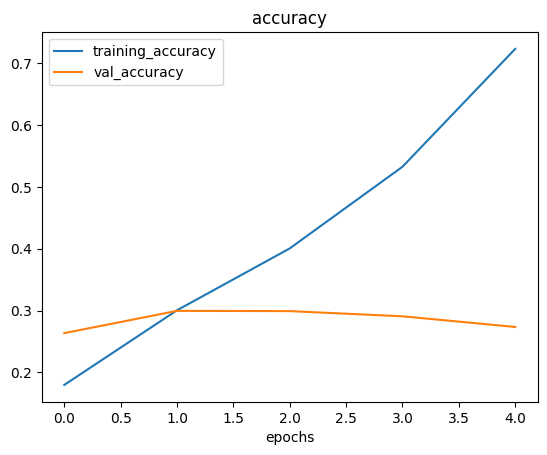

In [25]:
# Check out the model's loss curves
plot_loss_curves(history_8)

> What do these loss curves tell us?
>
> Well... it seems our model is **overfitting** the train set quite badly... in other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the training dataset

## 5. Adjust the model hyperparameters (to beat the baseline/reduce overfitting)

Due to its performance on the training data, it's clear our model is learning something...

However, it's not generalizing well to unseen data.

So, let's try and fix overfitting by...

* **Get more data** - having more data gives a model more opportunity to learn diverse patterns...
* **Simply the model** - if our current model is overfitting the data, it may be too complicated of a model. one way to simplify a model is to: reduce number of hidden units in layers
* **Use data augmentation** - data augmentation manipulates the training data in such a way to add more diversity to it (without altering the original data)
* **Use transfer learning** - transfer learning leverages the patterns another model has similar data to your own  and allows you ti use those patterns on your own dataset

In [27]:
# How about we try and simplify the model first?
model_8.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 222, 222, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 110, 110, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 108, 108, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 106, 106, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 53, 53, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 28090)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │         280,910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 851,762 (3.25 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 567,842 (2.17 MB)

In [28]:
# Let's try to remove 2 convolutional layers...
model_9 = Sequential([
    Input(shape=(224, 224, 3)),
    Rescaling(scale=1/255.),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax')
])

# Compile the model
model_9.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Fit the model
history_9 = model_9.fit(train_data,
           epochs=5,
           validation_data=test_data)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.2123 - loss: 2.1500 - val_accuracy: 0.3316 - val_loss: 1.9232
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.4196 - loss: 1.7145 - val_accuracy: 0.3356 - val_loss: 1.8810
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.5932 - loss: 1.2530 - val_accuracy: 0.3148 - val_loss: 2.1116
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.7720 - loss: 0.7520 - val_accuracy: 0.2880 - val_loss: 2.5352
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.8983 - loss: 0.3716 - val_accuracy: 0.2940 - val_loss: 3.1278


In [29]:
model_9.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 29160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │         291,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 878,402 (3.35 MB)

 Trainable params: 292,800 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 585,602 (2.23 MB)

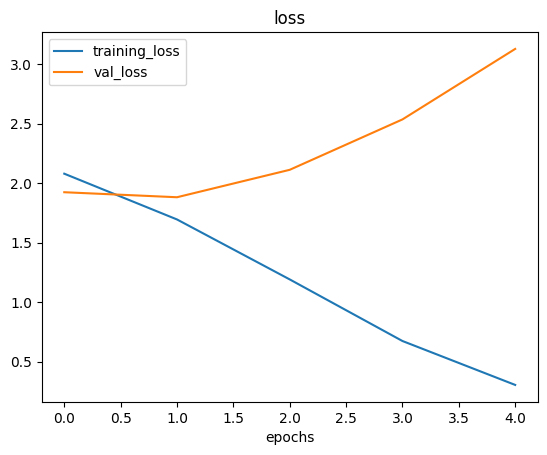

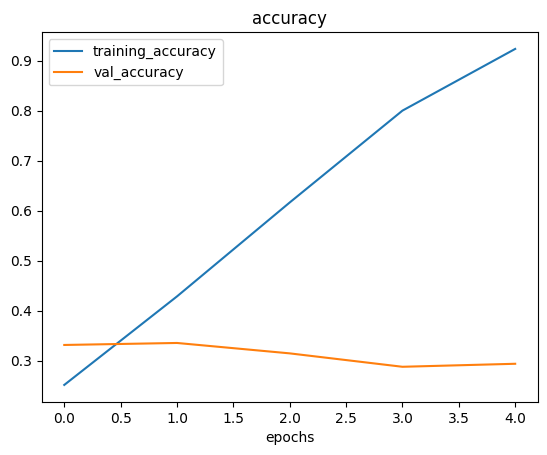

In [30]:
# Check out loss curves
plot_loss_curves(history_9)

Looks like our "simplifying the model" experiment didn't work... The accuracy went down and overfitting continued...

How about we try data augmentation

## Trying to reduce overfitting with data augmentation

Let's try and improve our model's results by using augmented training data...

Ideally, we want to:

* Reduce overfitting (get the train and validation loss curves closer)
* Improve validation accuracy

In [42]:
### Trying to reduce overfitting with data augmentation
# Создаем слой аугментации
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),  # Случайное отражение по горизонтали
    layers.RandomRotation(0.2),       # Поворот на ±20%
    layers.RandomZoom(0.2),           # Случайное увеличение/уменьшение
    layers.RandomContrast(0.1),       # Изменение контраста
    layers.RandomWidth(0.2),          # Случайное изменение ширины
    layers.RandomHeight(0.3),         # Случайное изменение высоты
], name="data_augmentation")

In [40]:
# Let's try to remove 2 convolutional layers...
model_10 = Sequential([
    Input(shape=(224, 224, 3)),
    data_augmentation,
    Rescaling(scale=1/255.),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    GlobalAveragePooling2D(),
    Dense(10, activation='softmax')
])

# Compile the model
model_10.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Fit the model
history_10 = model_10.fit(train_data,
           epochs=5,
           validation_data=test_data)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 49s 203ms/step - accuracy: 0.1001 - loss: 2.3001 - val_accuracy: 0.1224 - val_loss: 2.2794
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 55s 234ms/step - accuracy: 0.1291 - loss: 2.2692 - val_accuracy: 0.1764 - val_loss: 2.2380
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 245ms/step - accuracy: 0.1844 - loss: 2.2229 - val_accuracy: 0.2196 - val_loss: 2.1933
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 56s 236ms/step - accuracy: 0.2057 - loss: 2.1775 - val_accuracy: 0.2244 - val_loss: 2.1513
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 55s 232ms/step - accuracy: 0.2138 - loss: 2.1513 - val_accuracy: 0.2368 - val_loss: 2.1340


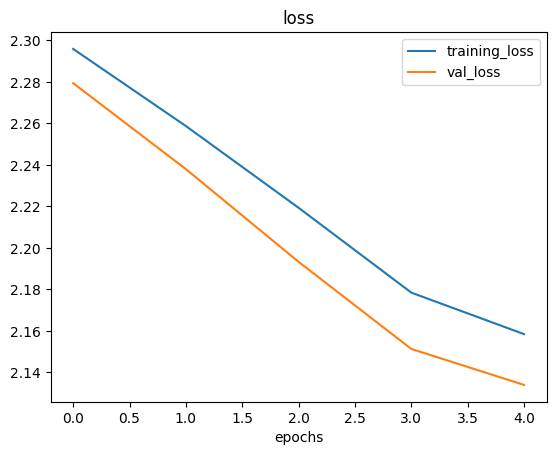

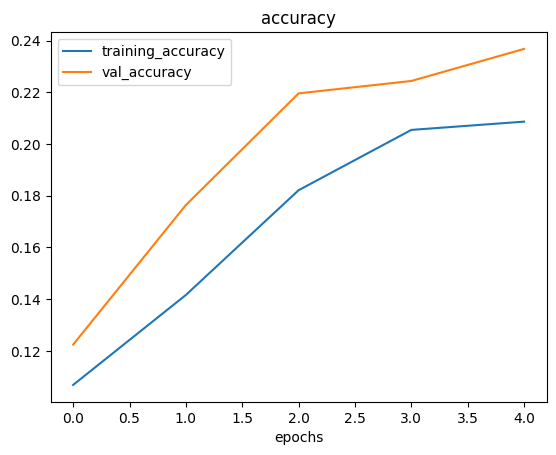

In [43]:
plot_loss_curves(history_10)

In [44]:
model_8.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.2842 - loss: 2.9010


[2.965496778488159, 0.2736000120639801]

In [45]:
model_10.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2431 - loss: 2.1221


[2.134000778198242, 0.23680000007152557]

> Woah! Thats looks much better, the loss curves are much closer to each other than the baseline model and they look like they're heading in the right direction (certainly not the wrong direction) so if we were to train for longer, we might see further improvement

## 6. Repeat until satisfied

We could keep going here... continally trying to bring our loss curves closer together and trying to improve the validation/test accuracy.

How?

By running lots of experiments, namely:

* restructuring our model's architecture (increasing layers/hidden units)
* adjust the learning rate
* try different methods of data augmentation (adjust the hyperparameters in our data_augmentation model)
* training for longer (e.g. 10 epochs instead of 5 epochs)
* try **transfer learning**

## Making prediction with our model